In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'g_Gr_MF_post += w * (1.0 - g_Gr_MF_post) (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'g_Gr_Go_post += w * (1.0 - g_Gr_Go_post) (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'g_Go_MF_post += w * (1.0 - g_Go_MF_post) (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code blo

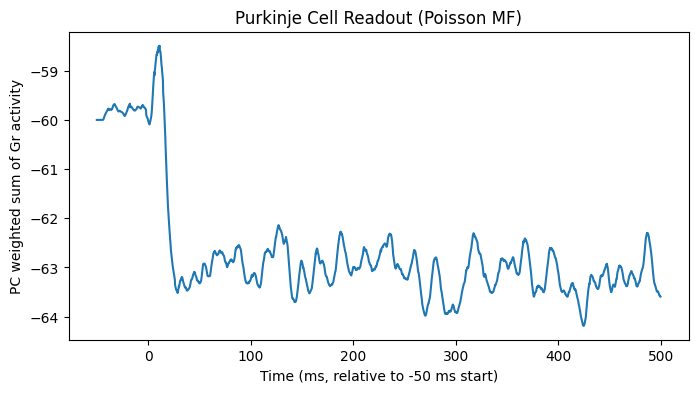

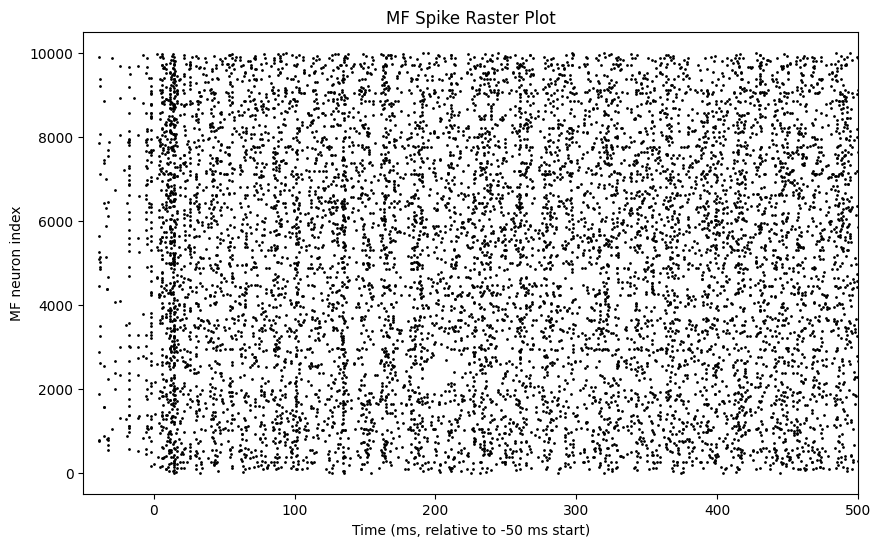

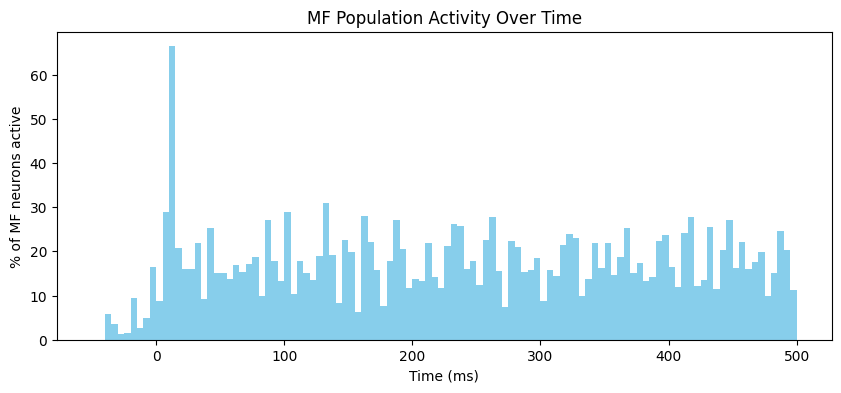

In [62]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# Set seeds for full reproducibility
# ---------------------
seed(42)                # Brian2 internal RNG
np.random.seed(42)      # NumPy RNG

start_scope()

# ---------------------
# Parameters
# ---------------------
Gr_N = 10000
Go_N = 900
MF_N = 500

tau_Gr_MF = 2.86*ms
tau_Gr_Go = 5.0*ms
tau_Go_MF = 2.87*ms
tau_Go_Gr = 2.86*ms
tau_Gr_Thr = 1.7*ms
tau_Go_Thr = 2.0*ms

E_leak = -60
E_ex = 0
E_inh = -80
g_Gr_leak = 0.07
g_Go_leak = 0.07

W_Gr_MF = 0.15
W_Gr_Go = 0.15
W_Go_MF = 0.007
W_Go_Gr = 0.008

Thr_Gr = -40
Thr_Go = -35
Max_Thr_Gr = -35
Max_Thr_Go = -25

# ---------------------
# Simulation timing
# ---------------------
sim_start = -50*ms
sim_end = 500*ms
duration = sim_end - sim_start
defaultclock.dt = 0.1*ms

# ---------------------
# Neuron Equations
# ---------------------
eqs_Gr = '''
dv/dt = (-g_Gr_leak*(v-E_leak) - g_Gr_MF*(v-E_ex) - g_Gr_Go*(v-E_inh)) / (2 * ms) : 1
dtheta/dt = -(theta-Thr_Gr)/tau_Gr_Thr : 1
dg_Gr_MF/dt = -g_Gr_MF/tau_Gr_MF : 1
dg_Gr_Go/dt = -g_Gr_Go/tau_Gr_Go : 1
'''

eqs_Go = '''
dv/dt = (-g_Go_leak*(v-E_leak) - g_Go_MF*(v-E_ex) - g_Go_Gr*(v-E_ex)) / (2 * ms) : 1
dtheta/dt = -(theta-Thr_Go)/tau_Go_Thr : 1
dg_Go_MF/dt = -g_Go_MF/tau_Go_MF : 1
dg_Go_Gr/dt = -g_Go_Gr/tau_Go_Gr : 1
'''

# ---------------------
# Neuron Groups
# ---------------------
Gr = NeuronGroup(Gr_N, eqs_Gr, threshold='v>theta', reset='v=E_leak; theta=Max_Thr_Gr', method='euler')
Gr.theta = Thr_Gr
Gr.v = E_leak
Go = NeuronGroup(Go_N, eqs_Go, threshold='v>theta', reset='v=E_leak; theta=Max_Thr_Go', method='euler')
Go.theta = Thr_Go
Go.v = E_leak

# ---------------------
# 2D positions
# ---------------------
Gr_pos = np.random.rand(Gr_N,2)
Go_pos = np.random.rand(Go_N,2)
MF_pos = np.random.rand(MF_N,2)

def select_within_square(pre_positions, post_position, n_inputs, span_size):
    x_min = max(0, post_position[0]-span_size/2)
    x_max = min(1, post_position[0]+span_size/2)
    y_min = max(0, post_position[1]-span_size/2)
    y_max = min(1, post_position[1]+span_size/2)
    mask = (pre_positions[:,0]>=x_min) & (pre_positions[:,0]<=x_max) & (pre_positions[:,1]>=y_min) & (pre_positions[:,1]<=y_max)
    candidate_indices = np.where(mask)[0]
    if len(candidate_indices)==0:
        return np.random.choice(len(pre_positions), n_inputs, replace=False)
    elif len(candidate_indices)<n_inputs:
        return np.random.choice(candidate_indices, n_inputs, replace=True)
    else:
        return np.random.choice(candidate_indices, n_inputs, replace=False)

span_size = 0.1

# ---------------------
# MF as PoissonGroup with time-varying rates
# ---------------------
MF_bg_fraction = 0.05
MF_CS_fraction = 0.2
MF_bg_rate = 50*Hz
MF_CS_rate = 100*Hz

# Background neurons
bg_idx = np.random.choice(MF_N, int(MF_N*MF_bg_fraction), replace=False)
# CS neurons
cs_idx = np.random.choice(MF_N, int(MF_N*MF_CS_fraction), replace=False)

dt_sim = defaultclock.dt
time_steps = int(duration / dt_sim) + 1

# Initialize rates
rates_array = np.zeros((MF_N, time_steps)) * Hz

# Background spikes: -45 to 0 ms
bg_start_idx = int((-45*ms - sim_start) / dt_sim)
bg_end_idx = int((0*ms - sim_start) / dt_sim)
rates_array[bg_idx, bg_start_idx:bg_end_idx] = MF_bg_rate

# CS spikes: 0 to 500 ms
cs_start_idx = int((0*ms - sim_start) / dt_sim)
cs_end_idx = int((500*ms - sim_start) / dt_sim)
rates_array[cs_idx, cs_start_idx:cs_end_idx] = MF_CS_rate

# Convert to Brian2 TimedArray
MF_rates = TimedArray(rates_array.T, dt=dt_sim)  # transpose: time along first axis

# PoissonGroup with time-varying rates
MF = PoissonGroup(MF_N, rates='MF_rates(t, i)')

# ---------------------
# Synapses
# ---------------------
MF_Go = Synapses(MF, Go, model='w:1', on_pre='g_Go_MF_post += w*(1-g_Go_MF_post)')
MF_Go_i, MF_Go_j = [], []
for j in range(Go_N):
    MF_Go_i.extend(select_within_square(MF_pos, Go_pos[j], 20, span_size))
    MF_Go_j.extend([j]*20)
MF_Go.connect(i=MF_Go_i,j=MF_Go_j)
MF_Go.w = W_Go_MF

Gr_Go = Synapses(Gr, Go, model='w:1', on_pre='g_Go_Gr_post += w*(1-g_Go_Gr_post)')
Gr_Go_i, Gr_Go_j = [], []
for j in range(Go_N):
    Gr_Go_i.extend(select_within_square(Gr_pos, Go_pos[j], 100, span_size))
    Gr_Go_j.extend([j]*100)
Gr_Go.connect(i=Gr_Go_i,j=Gr_Go_j)
Gr_Go.w = W_Gr_Go

MF_Gr = Synapses(MF, Gr, model='w:1', on_pre='g_Gr_MF_post += w*(1-g_Gr_MF_post)')
MF_Gr_i, MF_Gr_j = [], []
for j in range(Gr_N):
    MF_Gr_i.extend(select_within_square(MF_pos, Gr_pos[j], 3, span_size))
    MF_Gr_j.extend([j]*3)
MF_Gr.connect(i=MF_Gr_i,j=MF_Gr_j)
MF_Gr.w = W_Gr_MF

Go_Gr = Synapses(Go, Gr, model='w:1', on_pre='g_Gr_Go_post += w*(1-g_Gr_Go_post)')
Go_Gr_i, Go_Gr_j = [], []
for j in range(Gr_N):
    Go_Gr_i.extend(select_within_square(Go_pos, Gr_pos[j], 3, span_size))
    Go_Gr_j.extend([j]*3)
Go_Gr.connect(i=Go_Gr_i,j=Go_Gr_j)
Go_Gr.w = W_Gr_Go

# ---------------------
# PC readout
# ---------------------
PC = NeuronGroup(1, 'v : 1', method='euler')
@network_operation(dt=defaultclock.dt)
def update_PC():
    PC.v[0] = np.mean(Gr.v[:])  # or np.sum(Gr.g_Gr_MF + Gr.g_Gr_Go)

PC_mon = StateMonitor(PC, 'v', record=True)

MF_mon = SpikeMonitor(Gr, record=True)

# ---------------------
# Run simulation
# ---------------------
run(duration)

# ---------------------
# Plot PC activity
# ---------------------
plt.figure(figsize=(8,4))
plt.plot(PC_mon.t/ms + float(sim_start/ms), PC_mon.v[0])
plt.xlabel('Time (ms, relative to -50 ms start)')
plt.ylabel('PC weighted sum of Gr activity')
plt.title('Purkinje Cell Readout (Poisson MF)')
plt.show()

# ---------------------
# Percentage of active MFs per time bin
# ---------------------
bin_size = 5*ms
bins = np.arange(float(sim_start/ms), float(sim_end/ms)+float(bin_size/ms), float(bin_size/ms))
counts, _ = np.histogram(MF_mon.t/ms + float(sim_start/ms), bins=bins)
mf_percent = counts / MF_N * 100

# ---------------------
# Raster plot of MF spikes
# ---------------------
plt.figure(figsize=(10,6))
plt.scatter(MF_mon.t/ms + float(sim_start/ms), MF_mon.i, s=1, color='black')
plt.xlabel('Time (ms, relative to -50 ms start)')
plt.ylabel('MF neuron index')
plt.title('MF Spike Raster Plot')
plt.xlim(sim_start/ms, sim_end/ms)
plt.show()

plt.figure(figsize=(10,4))
plt.bar(bins[:-1], mf_percent, width=float(bin_size/ms), align='edge', color='skyblue')
plt.xlabel('Time (ms)')
plt.ylabel('% of MF neurons active')
plt.title('MF Population Activity Over Time')
plt.show()